# ⏱️ Energy Consumption — Time Series Models
### SARIMA · Holt-Winters · LSTM · XGBoost with Lag Features · Final Comparison
---
**Why time series?**  
Regular ML models treat every row as independent. But energy consumption at hour 14 depends on what happened at hours 13, 12, 11...  
Time series models explicitly capture this **temporal dependency**.

| Model | What it captures |
|-------|------------------|
| SARIMA | Linear trends + seasonality (hourly/daily cycles) |
| Holt-Winters | Exponential smoothing with trend & seasonal components |
| XGBoost + Lags | Nonlinear patterns using past values as features |
| LSTM | Deep learning — long-range temporal dependencies |

## 0 · Imports

In [10]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

# Classical time series
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ML
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import joblib

sns.set_theme(style='whitegrid', palette='pastel')
plt.rcParams.update({'figure.dpi': 100, 'axes.titlesize': 13})
pd.set_option('display.max_columns', None)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
print(f'✅ TensorFlow {tf.__version__} | Ready')

✅ TensorFlow 2.13.0 | Ready


## 1 · Load & Build Time Series

In [11]:
raw = pd.read_csv('data\Energy_consumption.csv')

# ── Sort by timestamp & set index ─────────────────────────────────────────
raw['Timestamp'] = pd.to_datetime(raw['Timestamp'])
raw = raw.sort_values('Timestamp').reset_index(drop=True)
raw = raw.set_index('Timestamp')

# Target series
ts = raw['EnergyConsumption'].copy()

print(f'Series length: {len(ts)}')
print(f'Date range:    {ts.index[0]}  →  {ts.index[-1]}')
print(f'Frequency:     hourly (expected)')
print(f'Missing timestamps: {pd.date_range(ts.index[0], ts.index[-1], freq="h").difference(ts.index).size}')
ts.head()

Series length: 1000
Date range:    2022-01-01 00:00:00  →  2022-02-11 15:00:00
Frequency:     hourly (expected)
Missing timestamps: 0


Timestamp
2022-01-01 00:00:00    75.364373
2022-01-01 01:00:00    83.401855
2022-01-01 02:00:00    78.270888
2022-01-01 03:00:00    56.519850
2022-01-01 04:00:00    70.811732
Name: EnergyConsumption, dtype: float64

## 2 · Time Series EDA

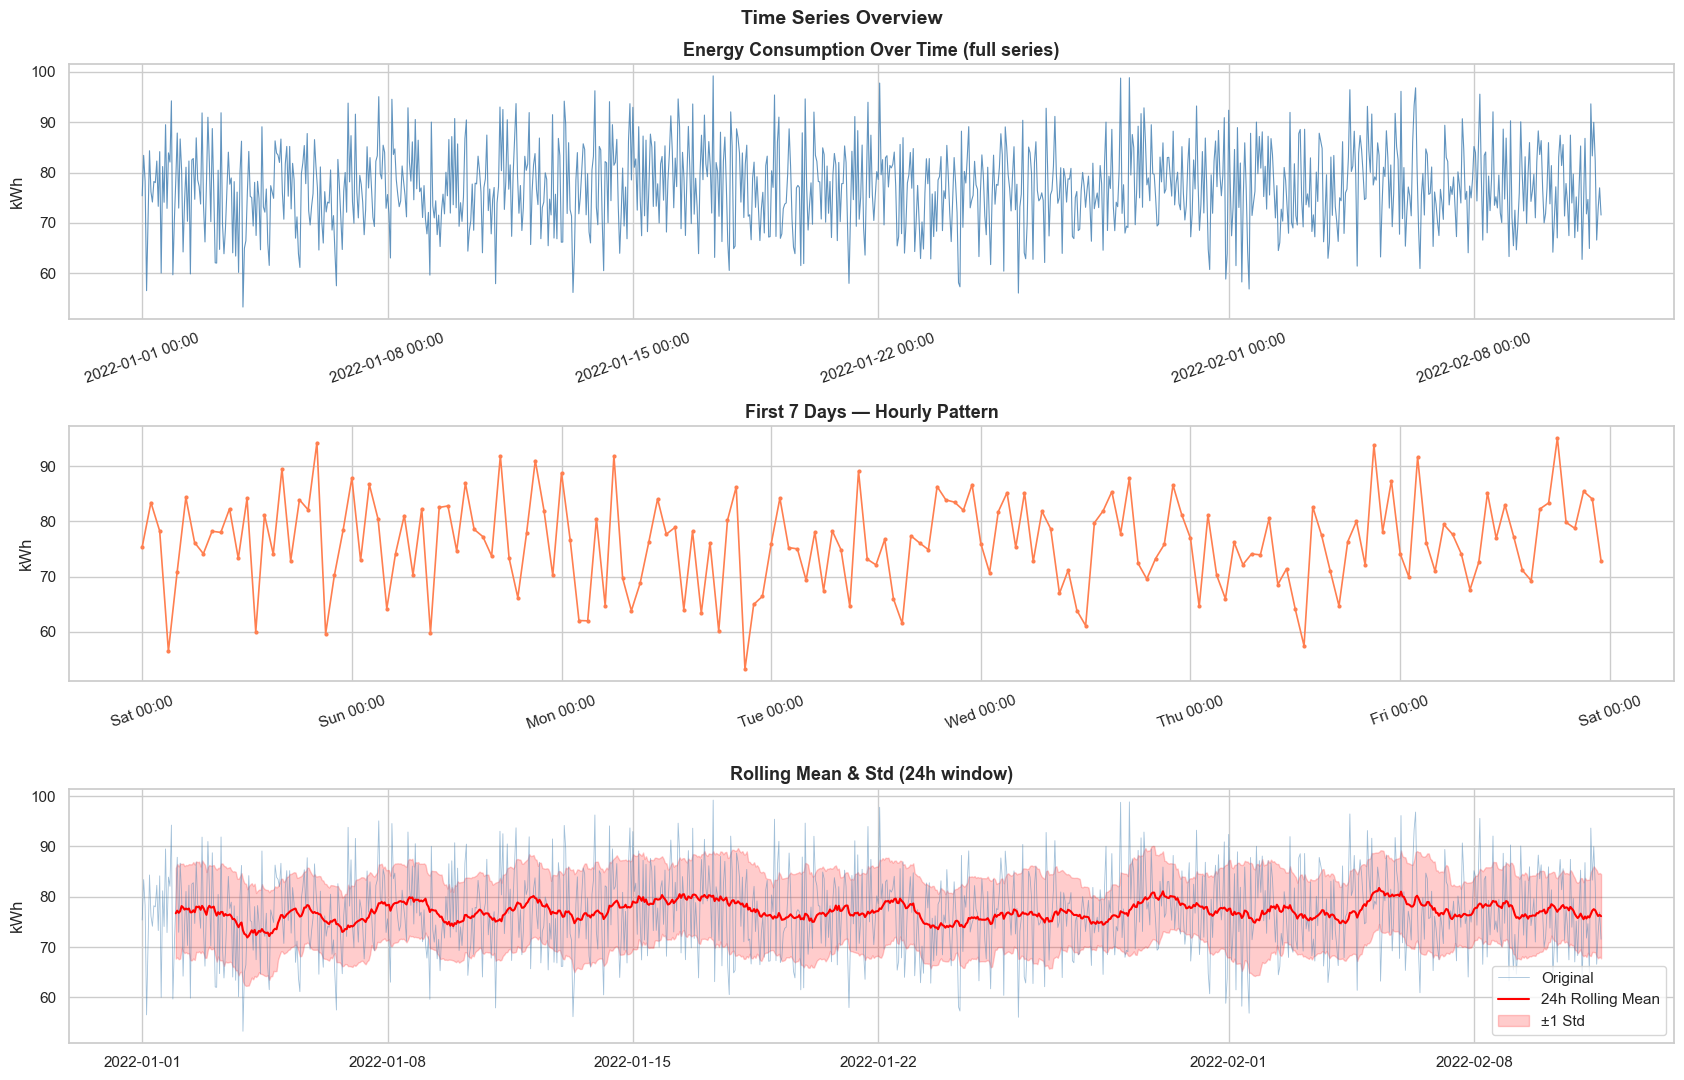

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(17, 11))

# Full series
axes[0].plot(ts.index, ts.values, color='steelblue', lw=0.8, alpha=0.85)
axes[0].set_title('Energy Consumption Over Time (full series)', fontweight='bold')
axes[0].set_ylabel('kWh')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=20)

# First 7 days
week = ts.iloc[:168]
axes[1].plot(week.index, week.values, color='coral', lw=1.2, marker='o', ms=2)
axes[1].set_title('First 7 Days — Hourly Pattern', fontweight='bold')
axes[1].set_ylabel('kWh')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=20)

# Rolling statistics
roll_mean = ts.rolling(window=24).mean()
roll_std  = ts.rolling(window=24).std()
axes[2].plot(ts.index,        ts.values,        color='steelblue', lw=0.6, alpha=0.5, label='Original')
axes[2].plot(roll_mean.index, roll_mean.values, color='red',       lw=1.5, label='24h Rolling Mean')
axes[2].fill_between(roll_mean.index,
                     roll_mean - roll_std,
                     roll_mean + roll_std,
                     alpha=0.2, color='red', label='±1 Std')
axes[2].set_title('Rolling Mean & Std (24h window)', fontweight='bold')
axes[2].set_ylabel('kWh'); axes[2].legend()

plt.suptitle('Time Series Overview', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3 · Stationarity Test & ACF/PACF

=== Augmented Dickey-Fuller Test ===
ADF Statistic : -31.5769
p-value       : 0.0000
Critical (5%) : -2.8644
✅ Series is STATIONARY (no differencing needed for SARIMA)


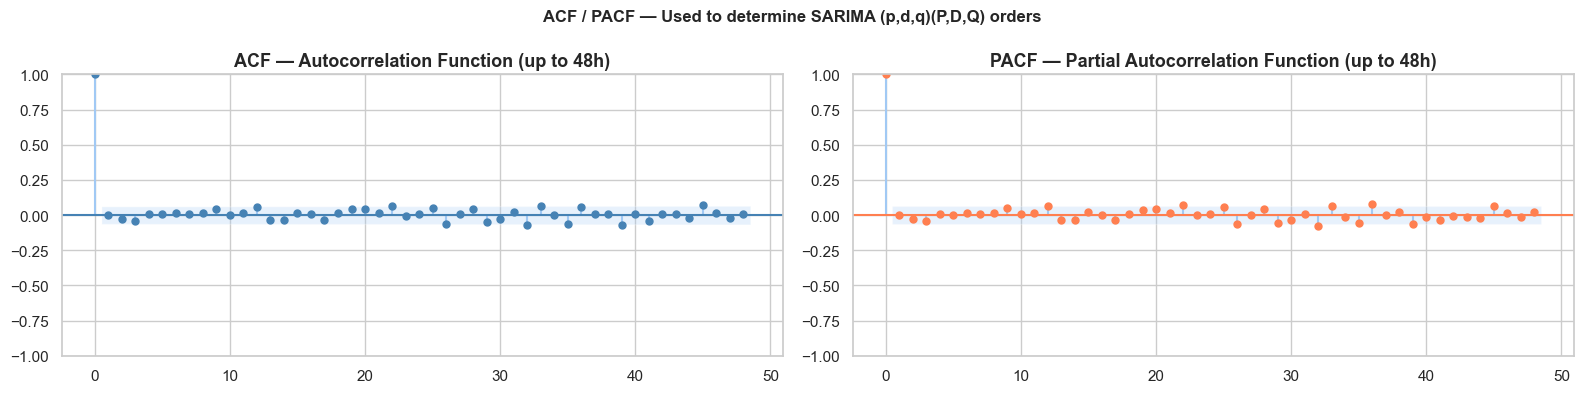


Reading the plots:
  ACF  → significant lags tell us the MA (q) order
  PACF → significant lags tell us the AR (p) order
  Lag 24 spike → strong 24-hour seasonality → seasonal period S=24



In [13]:
# ── Augmented Dickey-Fuller test ───────────────────────────────────────────
adf_result = adfuller(ts.dropna())
print('=== Augmented Dickey-Fuller Test ===')
print(f'ADF Statistic : {adf_result[0]:.4f}')
print(f'p-value       : {adf_result[1]:.4f}')
print(f'Critical (5%) : {adf_result[4]["5%"]:.4f}')
if adf_result[1] < 0.05:
    print('✅ Series is STATIONARY (no differencing needed for SARIMA)')
else:
    print('⚠️  Series is NON-STATIONARY → d=1 differencing needed')

# ── ACF & PACF ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf( ts, lags=48, ax=axes[0], color='steelblue')
plot_pacf(ts, lags=48, ax=axes[1], color='coral')
axes[0].set_title('ACF — Autocorrelation Function (up to 48h)', fontweight='bold')
axes[1].set_title('PACF — Partial Autocorrelation Function (up to 48h)', fontweight='bold')
plt.suptitle('ACF / PACF — Used to determine SARIMA (p,d,q)(P,D,Q) orders',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print('''
Reading the plots:
  ACF  → significant lags tell us the MA (q) order
  PACF → significant lags tell us the AR (p) order
  Lag 24 spike → strong 24-hour seasonality → seasonal period S=24
''')

## 4 · Train/Test Split (Time-Ordered — No Shuffling!)

Train: 800 rows  (2022-01-01 00:00:00 → 2022-02-03 07:00:00)
Test:  200  rows  (2022-02-03 08:00:00 → 2022-02-11 15:00:00)


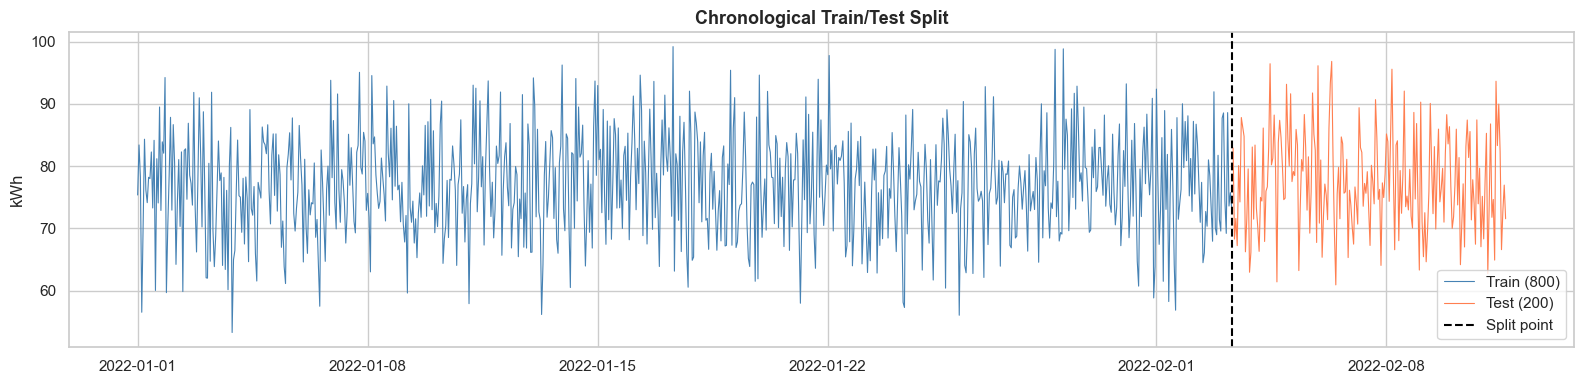

In [14]:
# For time series: ALWAYS split chronologically
TRAIN_RATIO = 0.8
split_idx   = int(len(ts) * TRAIN_RATIO)

ts_train = ts.iloc[:split_idx]
ts_test  = ts.iloc[split_idx:]

print(f'Train: {len(ts_train)} rows  ({ts_train.index[0]} → {ts_train.index[-1]})')
print(f'Test:  {len(ts_test)}  rows  ({ts_test.index[0]} → {ts_test.index[-1]})')

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(ts_train.index, ts_train.values, color='steelblue', lw=0.8, label=f'Train ({len(ts_train)})')
ax.plot(ts_test.index,  ts_test.values,  color='coral',     lw=0.8, label=f'Test ({len(ts_test)})')
ax.axvline(ts_train.index[-1], color='black', ls='--', lw=1.5, label='Split point')
ax.set_title('Chronological Train/Test Split', fontweight='bold')
ax.set_ylabel('kWh'); ax.legend()
plt.tight_layout()
plt.show()

## 5 · Model 1 — SARIMA
> Statistical model: captures linear autoregressive patterns + hourly seasonality

In [15]:
# SARIMA(p,d,q)(P,D,Q,S)
# From ACF/PACF: p=1 or 2, d=0 (stationary), q=1
# Seasonal: S=24 (hourly), P=1, D=0, Q=1
# Using simple order to keep training fast
print('Fitting SARIMA(1,0,1)(1,0,1,24) ...')
print('(This may take 1–3 minutes due to 24h seasonal period)')

sarima_model = SARIMAX(
    ts_train,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary().tables[0])

# Forecast on test set
sarima_pred = sarima_fit.forecast(steps=len(ts_test))
sarima_pred.index = ts_test.index

sarima_r2   = r2_score(ts_test, sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(ts_test, sarima_pred))
sarima_mae  = mean_absolute_error(ts_test, sarima_pred)

print(f'\nSARIMA  →  R²={sarima_r2:.4f} | RMSE={sarima_rmse:.2f} | MAE={sarima_mae:.2f}')

Fitting SARIMA(1,0,1)(1,0,1,24) ...
(This may take 1–3 minutes due to 24h seasonal period)
                                     SARIMAX Results                                      
Dep. Variable:                  EnergyConsumption   No. Observations:                  800
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -2771.394
Date:                            Fri, 27 Feb 2026   AIC                           5552.787
Time:                                    22:25:25   BIC                           5576.045
Sample:                                01-01-2022   HQIC                          5561.736
                                     - 02-03-2022                                         
Covariance Type:                              opg                                         

SARIMA  →  R²=-0.0301 | RMSE=7.95 | MAE=6.40


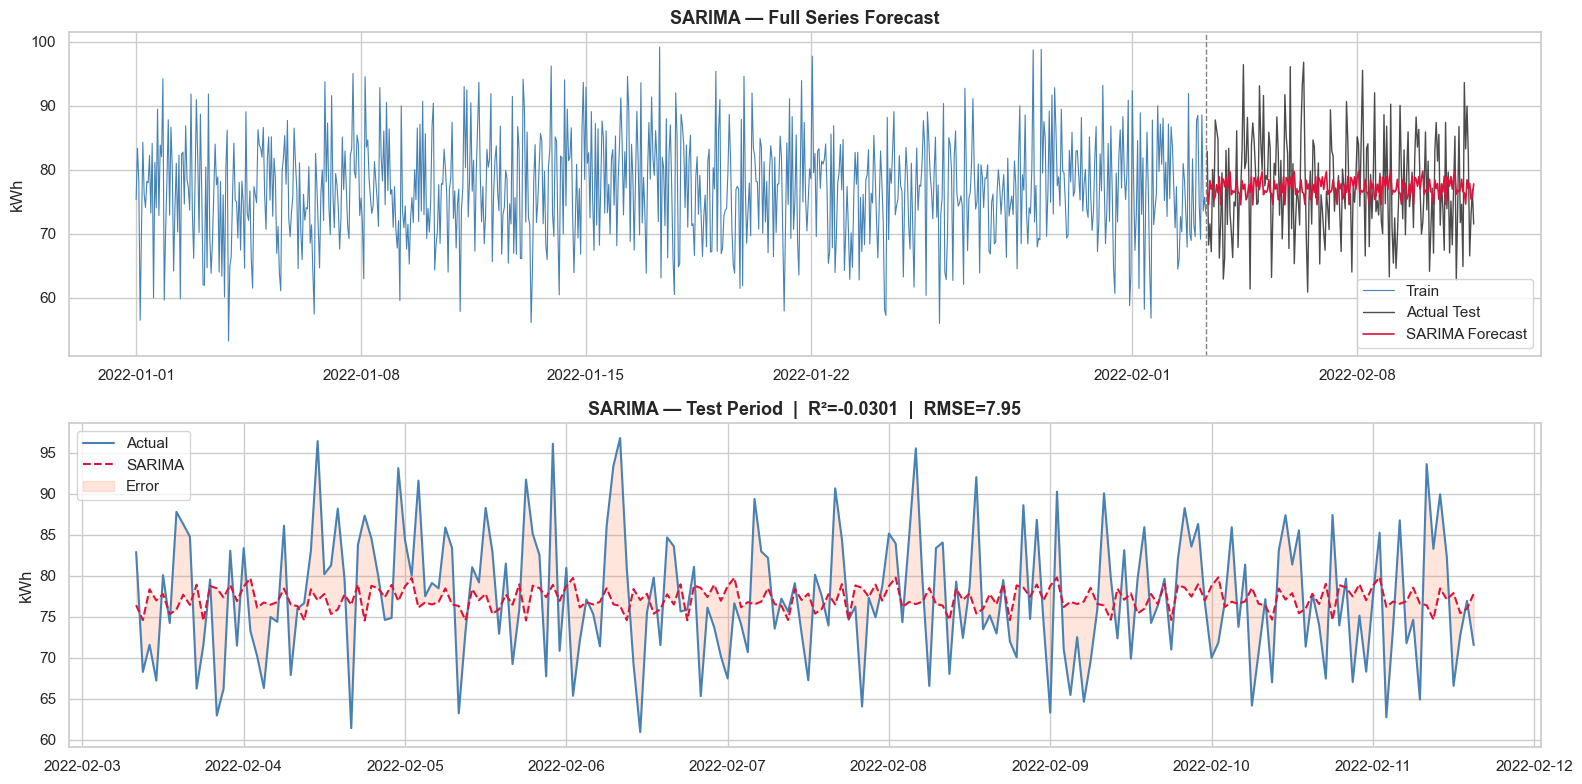

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Full view
axes[0].plot(ts_train.index, ts_train.values, color='steelblue', lw=0.8, label='Train')
axes[0].plot(ts_test.index,  ts_test.values,  color='black',     lw=1,   label='Actual Test', alpha=0.7)
axes[0].plot(sarima_pred.index, sarima_pred.values, color='crimson', lw=1.2, label='SARIMA Forecast')
axes[0].axvline(ts_train.index[-1], color='gray', ls='--', lw=1)
axes[0].set_title('SARIMA — Full Series Forecast', fontweight='bold')
axes[0].legend(); axes[0].set_ylabel('kWh')

# Zoom: test period only
axes[1].plot(ts_test.index,     ts_test.values,  color='steelblue', lw=1.5, label='Actual')
axes[1].plot(sarima_pred.index, sarima_pred.values, color='crimson', lw=1.5, ls='--', label='SARIMA')
axes[1].fill_between(ts_test.index,
                     ts_test.values,
                     sarima_pred.values,
                     alpha=0.2, color='coral', label='Error')
axes[1].set_title(f'SARIMA — Test Period  |  R²={sarima_r2:.4f}  |  RMSE={sarima_rmse:.2f}', fontweight='bold')
axes[1].legend(); axes[1].set_ylabel('kWh')

plt.tight_layout()
plt.show()

## 6 · Model 2 — Holt-Winters (Exponential Smoothing)
> Captures trend + seasonal patterns with exponential weighting

Fitting Holt-Winters with additive seasonality (period=24) ...
Holt-Winters → R²=-0.0291 | RMSE=7.94 | MAE=6.40


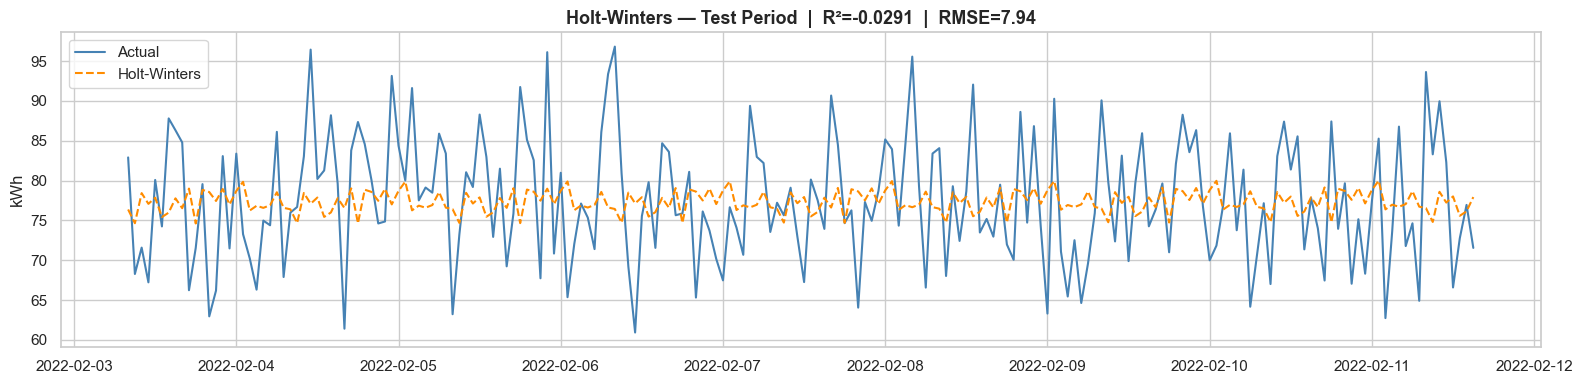

In [17]:
print('Fitting Holt-Winters with additive seasonality (period=24) ...')

hw_model = ExponentialSmoothing(
    ts_train,
    trend='add',
    seasonal='add',
    seasonal_periods=24,
    initialization_method='estimated'
)
hw_fit  = hw_model.fit(optimized=True, use_brute=False)
hw_pred = hw_fit.forecast(len(ts_test))
hw_pred.index = ts_test.index

hw_r2   = r2_score(ts_test, hw_pred)
hw_rmse = np.sqrt(mean_squared_error(ts_test, hw_pred))
hw_mae  = mean_absolute_error(ts_test, hw_pred)

print(f'Holt-Winters → R²={hw_r2:.4f} | RMSE={hw_rmse:.2f} | MAE={hw_mae:.2f}')

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(ts_test.index, ts_test.values, color='steelblue', lw=1.5, label='Actual')
ax.plot(hw_pred.index, hw_pred.values, color='darkorange', lw=1.5, ls='--', label='Holt-Winters')
ax.set_title(f'Holt-Winters — Test Period  |  R²={hw_r2:.4f}  |  RMSE={hw_rmse:.2f}', fontweight='bold')
ax.legend(); ax.set_ylabel('kWh')
plt.tight_layout()
plt.show()

## 7 · Model 3 — XGBoost with Lag Features
> Combines ML power with time series memory using engineered lag/rolling features

In [18]:
def create_lag_features(series, lags, rolling_windows):
    """Create lag + rolling features from a time series."""
    df = pd.DataFrame({'y': series})

    # Lag features — past values
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)

    # Rolling statistics
    for w in rolling_windows:
        df[f'roll_mean_{w}'] = df['y'].shift(1).rolling(w).mean()
        df[f'roll_std_{w}']  = df['y'].shift(1).rolling(w).std()
        df[f'roll_min_{w}']  = df['y'].shift(1).rolling(w).min()
        df[f'roll_max_{w}']  = df['y'].shift(1).rolling(w).max()

    # Difference features
    df['diff_1']  = df['y'].diff(1)
    df['diff_24'] = df['y'].diff(24)   # same hour yesterday

    # Calendar features
    df['hour']       = series.index.hour
    df['dayofweek']  = series.index.dayofweek
    df['month']      = series.index.month
    df['hour_sin']   = np.sin(2*np.pi*df['hour']      / 24)
    df['hour_cos']   = np.cos(2*np.pi*df['hour']      / 24)
    df['dow_sin']    = np.sin(2*np.pi*df['dayofweek'] / 7)
    df['dow_cos']    = np.cos(2*np.pi*df['dayofweek'] / 7)

    return df.dropna()


# Build lag feature dataset
LAGS    = [1, 2, 3, 6, 12, 24, 48]        # 1h, 2h, 3h, 6h, 12h, 24h, 48h ago
ROLLING = [3, 6, 12, 24]                   # 3h, 6h, 12h, 24h windows

lag_df = create_lag_features(ts, LAGS, ROLLING)
print(f'Lag feature dataset shape: {lag_df.shape}')
print(f'Features: {[c for c in lag_df.columns if c != "y"]}')

Lag feature dataset shape: (952, 33)
Features: ['lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'lag_48', 'roll_mean_3', 'roll_std_3', 'roll_min_3', 'roll_max_3', 'roll_mean_6', 'roll_std_6', 'roll_min_6', 'roll_max_6', 'roll_mean_12', 'roll_std_12', 'roll_min_12', 'roll_max_12', 'roll_mean_24', 'roll_std_24', 'roll_min_24', 'roll_max_24', 'diff_1', 'diff_24', 'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


In [19]:
# Time-ordered split (keep same ratio)
feat_cols = [c for c in lag_df.columns if c != 'y']
X_lag = lag_df[feat_cols]
y_lag = lag_df['y']

lag_split = int(len(lag_df) * TRAIN_RATIO)
X_lag_tr, X_lag_te = X_lag.iloc[:lag_split], X_lag.iloc[lag_split:]
y_lag_tr, y_lag_te = y_lag.iloc[:lag_split], y_lag.iloc[lag_split:]

print(f'XGB-Lag Train: {X_lag_tr.shape}  |  Test: {X_lag_te.shape}')

# TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

xgb_lag = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.5,
    n_jobs=-1,
    random_state=SEED,
    verbosity=0
)
xgb_lag.fit(
    X_lag_tr, y_lag_tr,
    eval_set=[(X_lag_te, y_lag_te)],
    verbose=False
)

xgb_lag_pred = xgb_lag.predict(X_lag_te)
xgb_lag_r2   = r2_score(y_lag_te, xgb_lag_pred)
xgb_lag_rmse = np.sqrt(mean_squared_error(y_lag_te, xgb_lag_pred))
xgb_lag_mae  = mean_absolute_error(y_lag_te, xgb_lag_pred)

# TimeSeriesSplit CV
cv_scores = []
for tr_idx, te_idx in tscv.split(X_lag):
    xgb_cv = XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        n_jobs=-1, random_state=SEED, verbosity=0)
    xgb_cv.fit(X_lag.iloc[tr_idx], y_lag.iloc[tr_idx])
    cv_scores.append(r2_score(y_lag.iloc[te_idx], xgb_cv.predict(X_lag.iloc[te_idx])))

print(f'XGBoost+Lags → R²={xgb_lag_r2:.4f} | RMSE={xgb_lag_rmse:.2f} | MAE={xgb_lag_mae:.2f}')
print(f'TimeSeriesCV R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

XGB-Lag Train: (761, 32)  |  Test: (191, 32)
XGBoost+Lags → R²=0.9783 | RMSE=1.16 | MAE=0.77
TimeSeriesCV R²: 0.9371 ± 0.0463


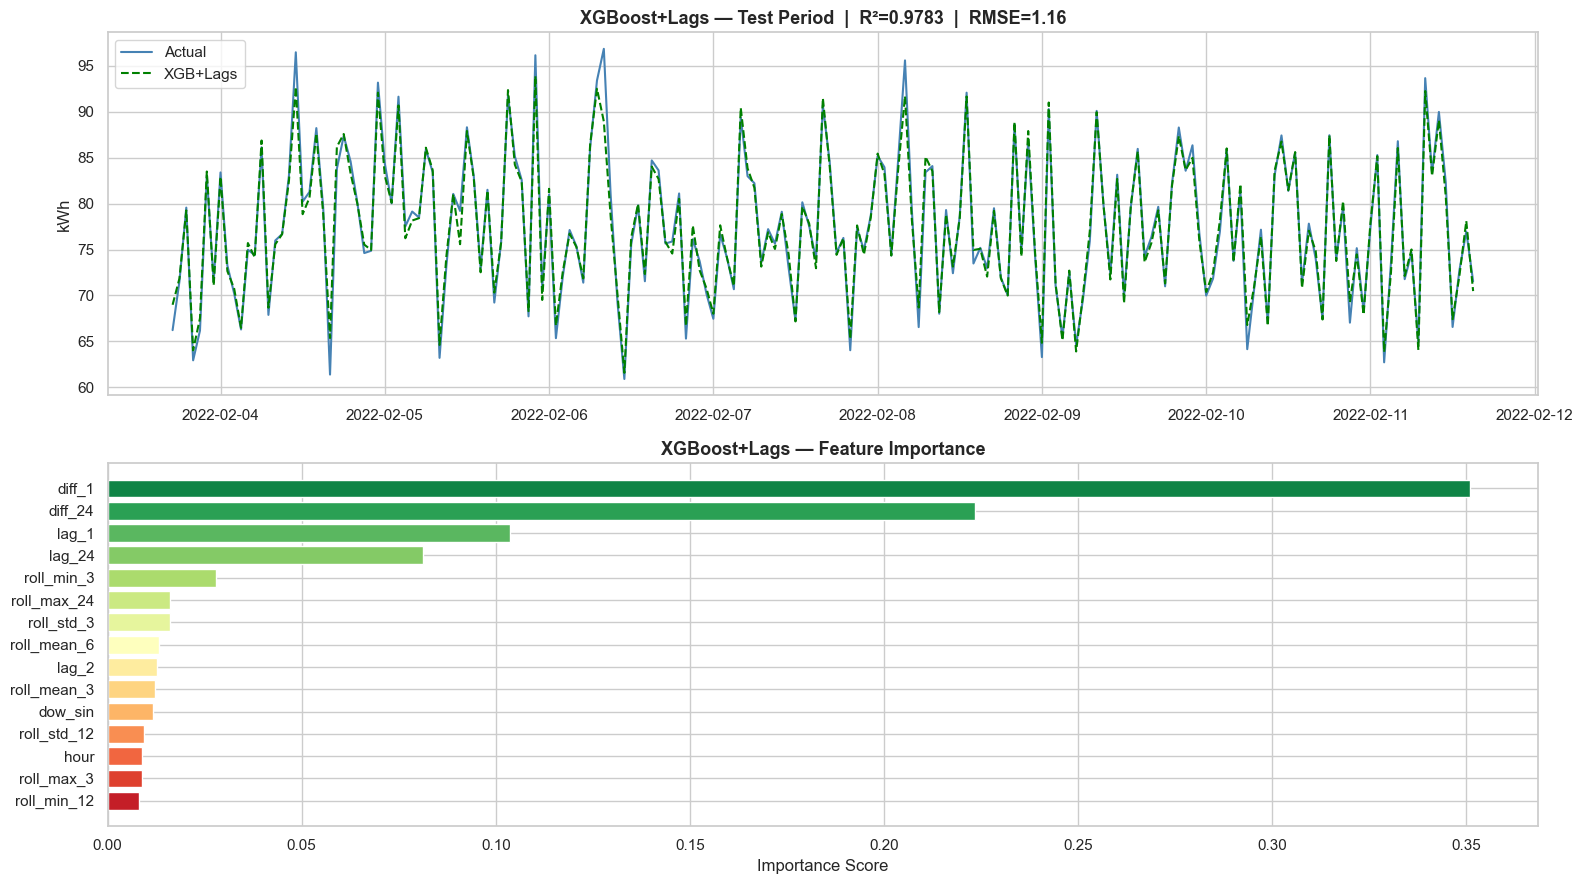

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(16, 9))

# Test period forecast
axes[0].plot(y_lag_te.index, y_lag_te.values, color='steelblue', lw=1.5, label='Actual')
axes[0].plot(y_lag_te.index, xgb_lag_pred,    color='green',     lw=1.5, ls='--', label='XGB+Lags')
axes[0].set_title(f'XGBoost+Lags — Test Period  |  R²={xgb_lag_r2:.4f}  |  RMSE={xgb_lag_rmse:.2f}',
                  fontweight='bold')
axes[0].legend(); axes[0].set_ylabel('kWh')

# Feature importance
imp = pd.DataFrame({'Feature': feat_cols,
                    'Importance': xgb_lag.feature_importances_})\
        .sort_values('Importance', ascending=True).tail(15)
axes[1].barh(imp['Feature'], imp['Importance'],
             color=sns.color_palette('RdYlGn', len(imp)), edgecolor='white')
axes[1].set_title('XGBoost+Lags — Feature Importance', fontweight='bold')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.show()

## 8 · Model 4 — LSTM (Deep Learning)
> Learns long-range temporal dependencies through gated memory cells

In [21]:
# ── Prepare sequences for LSTM ─────────────────────────────────────────────
LOOKBACK = 24   # use last 24 hours to predict next hour

# Scale to [0,1] — essential for LSTM
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
ts_scaled   = scaler_lstm.fit_transform(ts.values.reshape(-1, 1)).flatten()

def make_sequences(series, lookback):
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i-lookback:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X_seq, y_seq = make_sequences(ts_scaled, LOOKBACK)

# Time-ordered split
seq_split     = int(len(X_seq) * TRAIN_RATIO)
X_seq_tr, X_seq_te = X_seq[:seq_split], X_seq[seq_split:]
y_seq_tr, y_seq_te = y_seq[:seq_split], y_seq[seq_split:]

# Reshape for LSTM: (samples, timesteps, features)
X_seq_tr = X_seq_tr.reshape(X_seq_tr.shape[0], X_seq_tr.shape[1], 1)
X_seq_te = X_seq_te.reshape(X_seq_te.shape[0], X_seq_te.shape[1], 1)

print(f'LSTM Train: {X_seq_tr.shape}  |  Test: {X_seq_te.shape}')
print(f'Lookback window: {LOOKBACK} hours')

LSTM Train: (780, 24, 1)  |  Test: (196, 24, 1)
Lookback window: 24 hours


In [22]:
# ── Build LSTM model ───────────────────────────────────────────────────────
def build_lstm(lookback, units_1=64, units_2=32, dropout=0.2):
    model = Sequential([
        Input(shape=(lookback, 1)),
        LSTM(units_1, return_sequences=True),
        Dropout(dropout),
        LSTM(units_2, return_sequences=False),
        Dropout(dropout),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

lstm_model = build_lstm(LOOKBACK)
lstm_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

print('\nTraining LSTM...')
history = lstm_model.fit(
    X_seq_tr, y_seq_tr,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
    shuffle=False    # CRITICAL: never shuffle time series
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29857 (116.63 KB)
Trainable params: 29857 

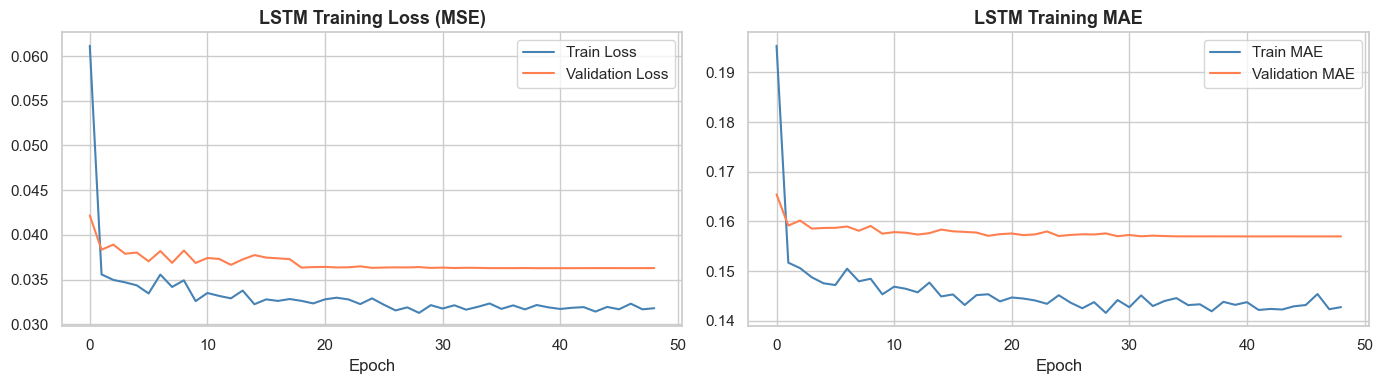

7/7 [==============================] - 1s 15ms/step

LSTM  →  R²=-0.0149 | RMSE=7.88 | MAE=6.40


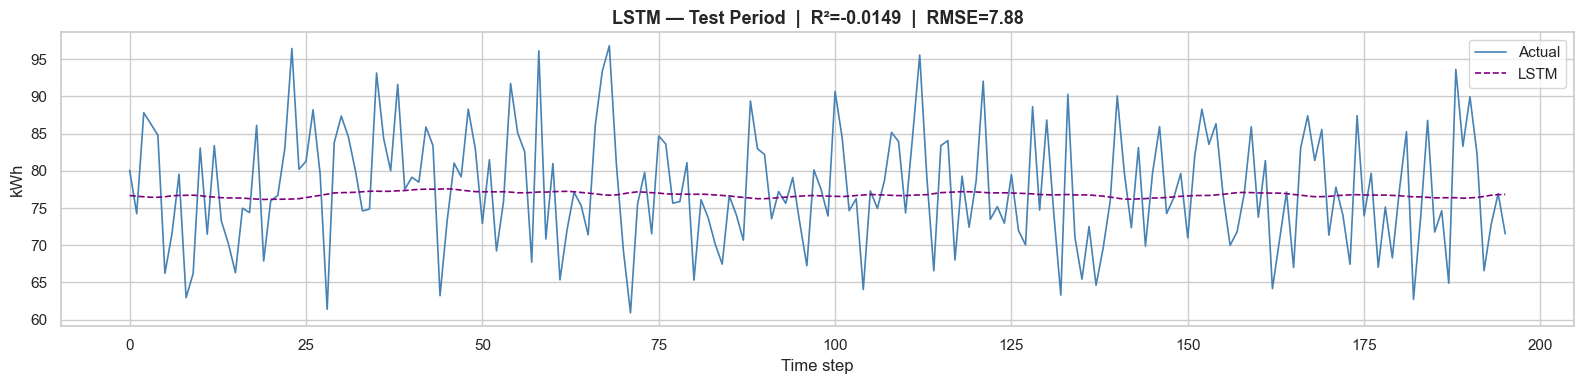

In [23]:
# ── Training curves ────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(history.history['loss'],     label='Train Loss',      color='steelblue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='coral')
axes[0].set_title('LSTM Training Loss (MSE)', fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].legend()

axes[1].plot(history.history['mae'],     label='Train MAE',      color='steelblue')
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='coral')
axes[1].set_title('LSTM Training MAE', fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].legend()

plt.tight_layout()
plt.show()

# ── Evaluate ───────────────────────────────────────────────────────────────
lstm_pred_scaled = lstm_model.predict(X_seq_te).flatten()
lstm_pred = scaler_lstm.inverse_transform(
    lstm_pred_scaled.reshape(-1, 1)).flatten()
y_actual_lstm = scaler_lstm.inverse_transform(
    y_seq_te.reshape(-1, 1)).flatten()

lstm_r2   = r2_score(y_actual_lstm, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_actual_lstm, lstm_pred))
lstm_mae  = mean_absolute_error(y_actual_lstm, lstm_pred)

print(f'\nLSTM  →  R²={lstm_r2:.4f} | RMSE={lstm_rmse:.2f} | MAE={lstm_mae:.2f}')

# Forecast plot
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(range(len(y_actual_lstm)), y_actual_lstm, color='steelblue', lw=1.2, label='Actual')
ax.plot(range(len(lstm_pred)),     lstm_pred,      color='purple',    lw=1.2, ls='--', label='LSTM')
ax.set_title(f'LSTM — Test Period  |  R²={lstm_r2:.4f}  |  RMSE={lstm_rmse:.2f}',
             fontweight='bold')
ax.legend(); ax.set_xlabel('Time step'); ax.set_ylabel('kWh')
plt.tight_layout()
plt.show()

## 9 · Final Model Comparison

=== ⏱️ Time Series Model Leaderboard ===


,R2,RMSE,MAE
Model,,,
XGBoost + Lag Features,0.9783,1.1557,0.7676
LSTM (24h lookback),-0.0149,7.8820,6.4036
Holt-Winters,-0.0291,7.9414,6.3966
"SARIMA(1,0,1)(1,0,1,24)",-0.0301,7.9451,6.3970


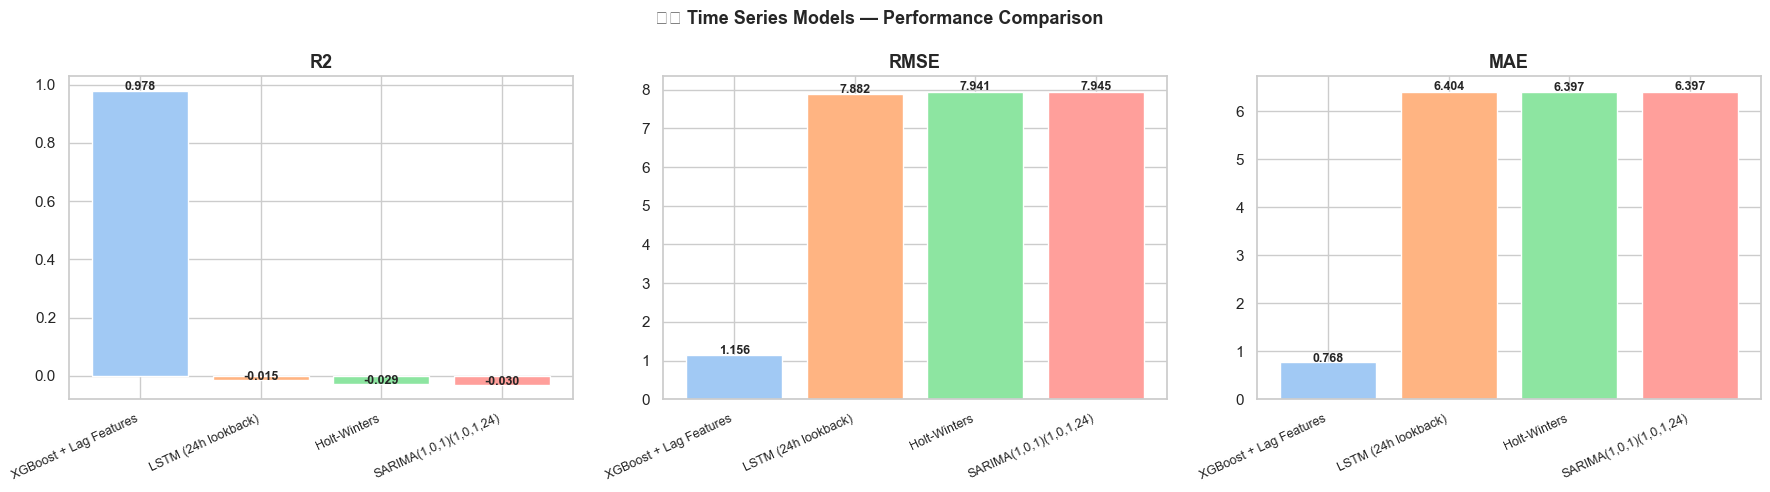

In [24]:
# Compile results
ts_results = pd.DataFrame([
    {'Model': 'SARIMA(1,0,1)(1,0,1,24)',  'R2': sarima_r2,   'RMSE': sarima_rmse,   'MAE': sarima_mae},
    {'Model': 'Holt-Winters',              'R2': hw_r2,       'RMSE': hw_rmse,       'MAE': hw_mae},
    {'Model': 'XGBoost + Lag Features',   'R2': xgb_lag_r2,  'RMSE': xgb_lag_rmse,  'MAE': xgb_lag_mae},
    {'Model': 'LSTM (24h lookback)',       'R2': lstm_r2,     'RMSE': lstm_rmse,     'MAE': lstm_mae},
]).set_index('Model').sort_values('R2', ascending=False)

print('=== ⏱️ Time Series Model Leaderboard ===')
display(ts_results.round(4))

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pal = sns.color_palette('pastel', len(ts_results))

for ax, metric in zip(axes, ['R2', 'RMSE', 'MAE']):
    bars = ax.bar(ts_results.index, ts_results[metric], color=pal, edgecolor='white')
    ax.set_title(metric, fontweight='bold')
    ax.set_xticklabels(ts_results.index, rotation=25, ha='right', fontsize=9)
    for b in bars:
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.005,
                f'{b.get_height():.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('⏱️ Time Series Models — Performance Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

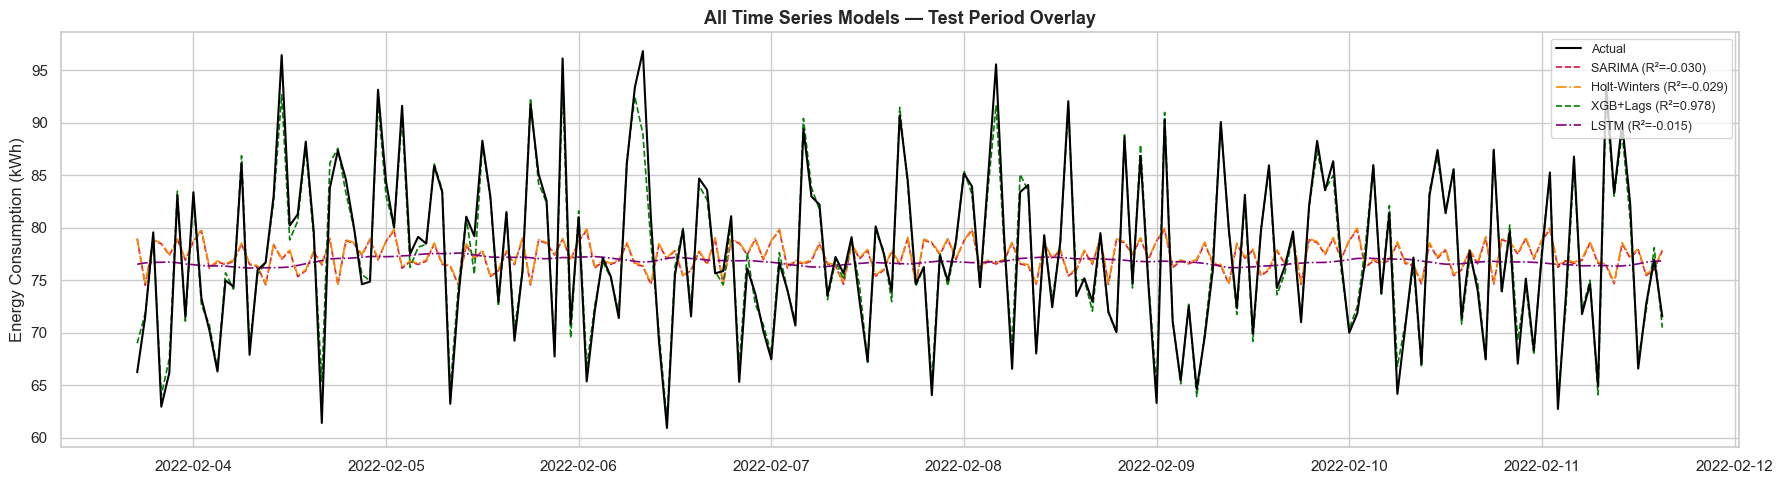

In [25]:
# Overlay all forecasts on test period
# Align to same index (XGBoost and LSTM may have slightly different lengths due to lag/lookback)
min_len = min(len(ts_test), len(xgb_lag_pred), len(lstm_pred))
idx     = ts_test.index[-min_len:]

fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(idx, ts_test.values[-min_len:],   color='black',      lw=1.5,  label='Actual',            zorder=5)
ax.plot(idx, sarima_pred.values[-min_len:], color='crimson',  lw=1.2, ls='--', label=f'SARIMA (R²={sarima_r2:.3f})')
ax.plot(idx, hw_pred.values[-min_len:],   color='darkorange', lw=1.2, ls='-.',  label=f'Holt-Winters (R²={hw_r2:.3f})')
ax.plot(idx, xgb_lag_pred[-min_len:],     color='green',      lw=1.2, ls='--', label=f'XGB+Lags (R²={xgb_lag_r2:.3f})')
ax.plot(idx, lstm_pred[-min_len:],        color='purple',     lw=1.2, ls='-.',  label=f'LSTM (R²={lstm_r2:.3f})')
ax.set_title('All Time Series Models — Test Period Overlay', fontweight='bold', fontsize=13)
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.show()

## 10 · Save Best Time Series Model

In [26]:
best_ts = ts_results['R2'].idxmax()
print(f'🏆 Best time series model: {best_ts}')
print(f'   R²={ts_results.loc[best_ts,"R2"]:.4f} | RMSE={ts_results.loc[best_ts,"RMSE"]:.2f}')

# Save XGBoost+Lags model (most deployable)
joblib.dump(xgb_lag,    'xgb_lag_model.pkl')
joblib.dump(feat_cols,  'xgb_lag_features.pkl')
print('\n✅ Saved: xgb_lag_model.pkl')

# Save LSTM
lstm_model.save('lstm_energy_model.keras')
joblib.dump(scaler_lstm, 'scaler_lstm.pkl')
print('✅ Saved: lstm_energy_model.keras')

print('''
=== SUMMARY ===
XGBoost+Lags is recommended for production:
  ✅ Fastest to train & predict
  ✅ Most interpretable (feature importance)
  ✅ Easily updatable as new data arrives
  ✅ No scaling or sequence prep needed at inference

LSTM is best when:
  ✅ You have much more data (10k+ rows)
  ✅ Long-range dependencies matter (>24h patterns)
''')

🏆 Best time series model: XGBoost + Lag Features
   R²=0.9783 | RMSE=1.16

✅ Saved: xgb_lag_model.pkl
✅ Saved: lstm_energy_model.keras

=== SUMMARY ===
XGBoost+Lags is recommended for production:
  ✅ Fastest to train & predict
  ✅ Most interpretable (feature importance)
  ✅ Easily updatable as new data arrives
  ✅ No scaling or sequence prep needed at inference

LSTM is best when:
  ✅ You have much more data (10k+ rows)
  ✅ Long-range dependencies matter (>24h patterns)



## 11 · Inference — Predict Next Hour
> Given the last 24 hours of consumption, predict the next hour

In [27]:
# ── XGBoost+Lags inference ──────────────────────────────────────────────────
# Use the last 48 actual values from the series to build one prediction
last_values = ts.values[-100:]  # take last 100h

# Rebuild lag features for the last row
tmp_series = pd.Series(last_values, index=ts.index[-100:])
tmp_df     = create_lag_features(tmp_series, LAGS, ROLLING)

last_row   = tmp_df[feat_cols].iloc[[-1]]
next_pred  = xgb_lag.predict(last_row)[0]
next_time  = ts.index[-1] + pd.Timedelta(hours=1)

print(f'Last known value : {ts.values[-1]:.2f} kWh  at {ts.index[-1]}')
print(f'Predicted next   : {next_pred:.2f} kWh  at {next_time}')

# ── LSTM inference ──────────────────────────────────────────────────────────
last_24_scaled = scaler_lstm.transform(
    ts.values[-LOOKBACK:].reshape(-1,1)).flatten()
lstm_input     = last_24_scaled.reshape(1, LOOKBACK, 1)
lstm_next_scaled = lstm_model.predict(lstm_input, verbose=0)[0,0]
lstm_next = scaler_lstm.inverse_transform([[lstm_next_scaled]])[0,0]

print(f'\nLSTM prediction  : {lstm_next:.2f} kWh  at {next_time}')

Last known value : 71.55 kWh  at 2022-02-11 15:00:00
Predicted next   : 70.48 kWh  at 2022-02-11 16:00:00

LSTM prediction  : 76.84 kWh  at 2022-02-11 16:00:00
